In [25]:
import collections
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
import numpy as np
from statistics import mean 
import time
from scipy import stats
import networkx as nx
from sklearn import preprocessing

In [26]:
"""Benchmark dataset reader."""
ts = time.time()

from littleballoffur.data_reader import GraphReader

reader = GraphReader('bitcoinalpha')

graph = reader.get_graph()

time.time() - ts

0.04725289344787598

In [27]:
nx.is_weighted(graph)

True

Non Back Tracking Random Walk Sampler

In [28]:
ts = time.time()
#Random walk

from littleballoffur.exploration_sampling import MetropolisHastingsRandomWalkSampler

sampler = MetropolisHastingsRandomWalkSampler(number_of_nodes = 750)

nrw_graph = sampler.sample(graph)

print('original graph nodes', len(graph.nodes))
print('after sampling graph nodes', len(nrw_graph.nodes))
time.time() - ts

original graph nodes 3783
after sampling graph nodes 750


0.013000965118408203

In [29]:
nx.is_weighted(nrw_graph)

True

Spiky Ball Sampler

In [30]:
ts = time.time()

from littleballoffur.exploration_sampling import SpikyBallSamplerWeighted

sampler = SpikyBallSamplerWeighted(number_of_nodes= 750,mode = "hubball")

spiky_graph = sampler.sample(graph)

print('original graph nodes', len(graph.nodes))
print('after sampling graph nodes', len(spiky_graph.nodes))
time.time() - ts

original graph nodes 3783
after sampling graph nodes 750


1.7045433521270752

In [31]:
nx.is_weighted(spiky_graph)

True

# Statistics

In [32]:
ts = time.time()
#Original graph
print('Average Clustering - Original: ',nx.average_clustering(graph))

print('-------------------------------------------------------------------')

#Non Back Tracking Random Walk
print('Average Clustering - Non Back Tracking Random Walk: ',nx.average_clustering(nrw_graph))
#Spiky Ball
print('Average Clustering - Spiky ball: ',nx.average_clustering(spiky_graph))
time.time() - ts


Average Clustering - Original:  0.1766290303590772
-------------------------------------------------------------------
Average Clustering - Non Back Tracking Random Walk:  0.23586903101280665
Average Clustering - Spiky ball:  0.3026293754195666


0.4650590419769287

In [33]:
ts = time.time()
#Original graph
print('Triangles Percentage - Original: ',(sum(nx.triangles(graph).values()) / 3)/len(graph.nodes))

print('-------------------------------------------------------------------')

#Non Back Tracking Random Walk
print('Triangles Percentage- Non Back Tracking Random Walk: ',(sum(nx.triangles(nrw_graph).values()) / 3)/len(nrw_graph.nodes))
#Spiky Ball
print('Triangles Percentage- Spiky Ball: ',(sum(nx.triangles(spiky_graph).values()) / 3)/len(spiky_graph.nodes))

time.time() - ts



Triangles Percentage - Original:  5.855934443563309
-------------------------------------------------------------------
Triangles Percentage- Non Back Tracking Random Walk:  15.174666666666667
Triangles Percentage- Spiky Ball:  15.857333333333333


0.4801912307739258

In [34]:
ts = time.time()
#Original graph
print('Size of largest connected component - Original: ',len(max(nx.connected_components(graph))))

print('-------------------------------------------------------------------')

#Non Back Tracking Random Walk
print('Size of largest connected component- Non Back Tracking Random Walk: ',len(max(nx.connected_components(nrw_graph))))
#Spiky Ball
print('Size of largest connected component- Spiky Ball: ',len(max(nx.connected_components(spiky_graph))))


time.time() - ts


Size of largest connected component - Original:  3775
-------------------------------------------------------------------
Size of largest connected component- Non Back Tracking Random Walk:  750
Size of largest connected component- Spiky Ball:  735


0.01136326789855957

In [35]:
ts = time.time()
#Original graph
print('Degree Assortativity Coefficient - Original: ',nx.degree_assortativity_coefficient(graph))

print('-------------------------------------------------------------------')


#Non Back Tracking Random Walk
print('Degree Assortativity Coefficient - Non Back Tracking Random Walk: ',nx.degree_assortativity_coefficient(nrw_graph))
#Spiky Ball
print('Degree Assortativity Coefficient - Spiky Ball: ',nx.degree_assortativity_coefficient(spiky_graph))

time.time() - ts



Degree Assortativity Coefficient - Original:  -0.16851576112150454
-------------------------------------------------------------------
Degree Assortativity Coefficient - Non Back Tracking Random Walk:  -0.04347996156841106
Degree Assortativity Coefficient - Spiky Ball:  -0.2736420841298842


0.41260409355163574

# Matching Patterns / Plots

In [36]:
def degree_distributon(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    return deg,cnt

In [37]:
ts = time.time()
#Original 
deg,cnt = degree_distributon(graph)

#Non Back Tracking Random Walk
deg1,cnt1 = degree_distributon(nrw_graph)
#Spiky
deg2,cnt2 = degree_distributon(spiky_graph)

time.time() - ts

0.010535001754760742

Text(0.5, 0, 'Degree')

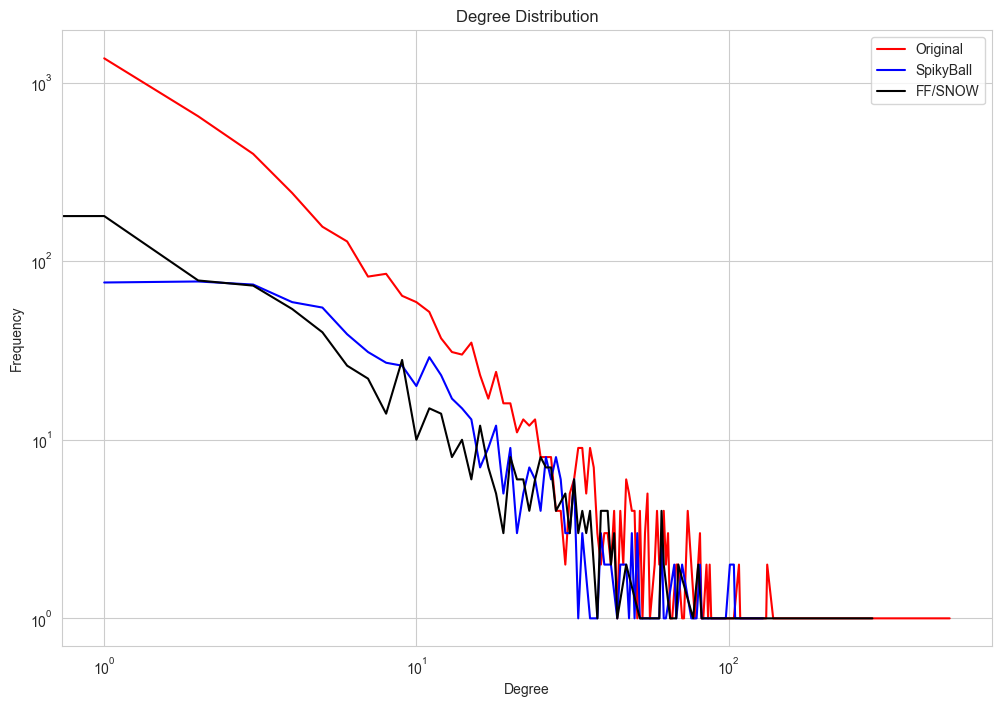

In [38]:
plt.figure(figsize=(12, 8))
plt.loglog(deg, cnt, 'r-', label='original')
plt.loglog(deg1,cnt1, 'b-', label='Non Back Tracking Random Walk')
plt.loglog(deg2,cnt2, 'black', label='SpikyBall')

plt.legend(['Original','SpikyBall','FF/SNOW','SP'])
plt.title("Degree Distribution")
plt.ylabel("Frequency")
plt.yscale('log')
# plt.xscale('log')
plt.xlabel("Degree")

In [39]:
def degree_clustering(original, sample):
   degree = sample.degree()
   degree_list,degrees,clustering_list,kstest = [],[],[],[]
   
   for n,m in degree:
      degree_list.append(m)
   degree_list
   degree_np = np.asarray(sorted(degree_list))
  

   for k in range(len(np.unique(degree_np))):
      sample_nodes_degree_k = ([u for u in sample.nodes() if sample.degree(u) == k])
      if len(sample_nodes_degree_k) != 0:
        sample_clustering_coef = nx.clustering(sample, sample_nodes_degree_k)
        original_nodes_degree_k = ([u for u in original.nodes() if original.degree(u) == k])
        original_clustering_coef = nx.clustering(original, original_nodes_degree_k)
        avg_clustering_coeff = nx.average_clustering(sample, sample_nodes_degree_k)

        original_clustering_coef = np.fromiter(original_clustering_coef.values(), dtype=float)
        
        sample_clustering_coef = np.fromiter(sample_clustering_coef.values(), dtype=float)
        
        if len(original_clustering_coef) != 0:
         if len(sample_clustering_coef) != 0:
            ks_test = stats.ks_2samp(preprocessing.scale(original_clustering_coef), preprocessing.scale(sample_clustering_coef))[0]

            kstest.append(ks_test)
        degrees.append(k)
        clustering_list.append(avg_clustering_coeff)
      nodes_degree_k = []
    
   avg_kstest = np.average(kstest)
         
   return degrees,clustering_list,avg_kstest 

In [40]:
ts = time.time()
degrees,clustering_list,avg_kstest = degree_clustering(graph,graph)
degrees1,clustering_list1,avg_kstest1 = degree_clustering(graph,nrw_graph)
degrees2,clustering_list2,avg_kstest2 = degree_clustering(graph,spiky_graph)

time.time() - ts

2.136956214904785

Text(0.5, 0, 'Node Degree')

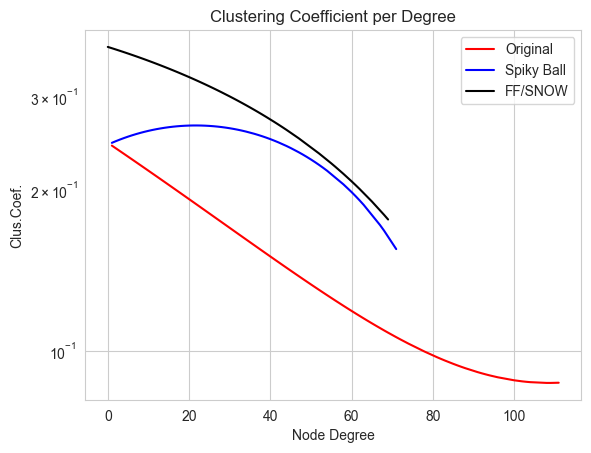

In [41]:
z = np.polyfit(degrees, clustering_list,2)
p = np.poly1d(z)
plt.plot(degrees,p(degrees),"red")

z = np.polyfit(degrees1, clustering_list1,2)
p = np.poly1d(z)
plt.plot(degrees1,p(degrees1),"blue")

z = np.polyfit(degrees2, clustering_list2,2)
p = np.poly1d(z)
plt.plot(degrees2,p(degrees2),"black")

plt.legend(['Original','Spiky Ball','FF/SNOW','SP'])
plt.title("Clustering Coefficient per Degree")
plt.ylabel("Clus.Coef.")
# plt.xscale('log')
plt.yscale('log')
plt.xlabel("Node Degree")

In [42]:
def average_degree_neighbor(original, sample):
   degree = sample.degree()
   degree_list,degrees,neighbor_list,kstest = [],[],[],[]
   for n,m in degree:
      degree_list.append(m)
   degree_list
   degree_np = np.asarray(sorted(degree_list))
  

   for k in range(len(np.unique(degree_np))):
      nodes_degree_k = ([u for u in sample.nodes() if sample.degree(u) == k])
      # print(nodes_degree_k)
      if len(nodes_degree_k) != 0:
         sample_aver_neighbor_deg = nx.average_neighbor_degree( sample , nodes = nodes_degree_k)

         original_nodes_degree_k = ([u for u in original.nodes() if original.degree(u) == k])
         original_aver_neighbor_deg = nx.average_neighbor_degree( original , nodes = original_nodes_degree_k)


         original_avg_neighbor_degree = np.fromiter(original_aver_neighbor_deg.values(), dtype=float)
         sample_aver_neighbor_deg = np.fromiter(sample_aver_neighbor_deg.values(), dtype=float)

         if len(original_avg_neighbor_degree) != 0:
            if len(sample_aver_neighbor_deg) != 0:
               ks_test = stats.ks_2samp(preprocessing.scale(original_avg_neighbor_degree), preprocessing.scale(sample_aver_neighbor_deg))[0]
         
               kstest.append(ks_test)

         list_avg = mean(sample_aver_neighbor_deg) 
         degrees.append(k)
         neighbor_list.append(list_avg)
      nodes_degree_k = []
   
   kstest_neighbor_degree = np.average(kstest)
         
   return degrees,neighbor_list,kstest_neighbor_degree

In [43]:
ts = time.time()
degrees,neighbor_list,kstest_neighbor_degree = average_degree_neighbor(graph,graph)
degrees1,neighbor_list1,kstest_neighbor_degree1 = average_degree_neighbor(graph,nrw_graph)
degrees2,neighbor_list2,kstest_neighbor_degree2 = average_degree_neighbor(graph,spiky_graph)
time.time() - ts

1.7750272750854492

Text(0.5, 0, 'Node Degree')

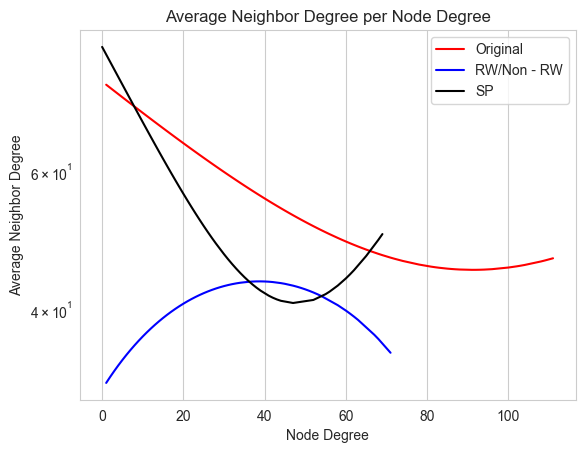

In [44]:
z = np.polyfit(degrees, neighbor_list,2)
p = np.poly1d(z)
plt.plot(degrees,p(degrees),"r")

z = np.polyfit(degrees1, neighbor_list1,2)
p = np.poly1d(z)
plt.plot(degrees1,p(degrees1),"blue")

z = np.polyfit(degrees2, neighbor_list2,2)
p = np.poly1d(z)
plt.plot(degrees2,p(degrees2),"black")

plt.legend(['Original','RW/Non - RW','SP', 'FF/SNOW'])
plt.title("Average Neighbor Degree per Node Degree")
plt.ylabel("Average Neighbor Degree")
# plt.xscale('log')
plt.yscale('log')
plt.xlabel("Node Degree")

# KOLMOGOROV-SMIRNOV TEST

KS-TEST FOR DEGREE DISTRIBUTION

In [45]:
#SCALING THE DATA

std_deg = preprocessing.scale(deg)
std_deg1 = preprocessing.scale(deg1)
std_deg2 = preprocessing.scale(deg2)

In [46]:
print("NRW ---> ", stats.ks_2samp(std_deg, std_deg1))
print("Spiky ---> ", stats.ks_2samp(std_deg, std_deg2))

NRW --->  KstestResult(statistic=0.15331260464003826, pvalue=0.21427564576020658)
Spiky --->  KstestResult(statistic=0.055590178237567, pvalue=0.9975946692474017)


KS-TEST FOR AVERAGE CLUSTERING COEFFICIENT PER NODE DEGREE

In [47]:
print("NRW ---> ", avg_kstest1)
print("Spiky ---> ", avg_kstest2)

NRW --->  0.35704313704693835
Spiky --->  0.31695372130280874


KS-TEST FOR AVERAGE NEIGHBORHOOD DEGREE PER NODE DEGREE

In [48]:
print("NRW ---> ", kstest_neighbor_degree1)
print("Spiky ---> ", kstest_neighbor_degree2)

NRW --->  0.3272482907170103
Spiky --->  0.2916937945560268
